In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
data = pd.read_excel("./output/hasil_perbandingan_pos.xlsx")

In [3]:
def calculate_pos_changes(pos_dist_ori, pos_dist_aug):
    changes = {}
    for pos_tag in set(pos_dist_ori.keys()).union(set(pos_dist_aug.keys())):
        ori_count = pos_dist_ori.get(pos_tag, 0)
        aug_count = pos_dist_aug.get(pos_tag, 0)
        changes[pos_tag] = aug_count - ori_count  # Perubahan jumlah POS
    return changes

In [4]:
# perubahan POS
data['pos_changes'] = data.apply(lambda row: calculate_pos_changes(eval(row['pos-dist-original']), eval(row['pos-dist'])), axis=1)


In [6]:
print(data[['question_id', 'version', 'levenshtein_sim', 'jaccard_sim', 'cosine_sim', 'pos_changes']].head(10))

   question_id  version  levenshtein_sim  jaccard_sim  cosine_sim  \
0            1        2         0.272727     0.222222    0.363636   
1            1        3         0.727273     0.571429    0.727273   
2            2        2         0.551724     0.380952    0.552052   
3            2        3         0.387097     0.291667    0.453743   
4            4        2         0.600000     0.526316    0.688847   
5            4        3         0.733333     0.705882    0.814092   
6            5        2         0.608696     0.400000    0.667124   
7            5        3         0.400000     0.300000    0.482805   
8            6        2         0.666667     0.533333    0.700649   
9            6        3         0.636364     0.466667    0.636364   

                                         pos_changes  
0  {'VSP': 1, 'S--': -1, 'R--': 0, 'X--': 0, 'VSA...  
1  {'S--': 0, 'R--': 0, 'X--': 0, 'VSA': 1, 'NSD'...  
2  {'S--': 0, 'R--': 0, 'X--': -1, 'VSA': 0, 'NSD...  
3  {'S--': 0, 'R--':

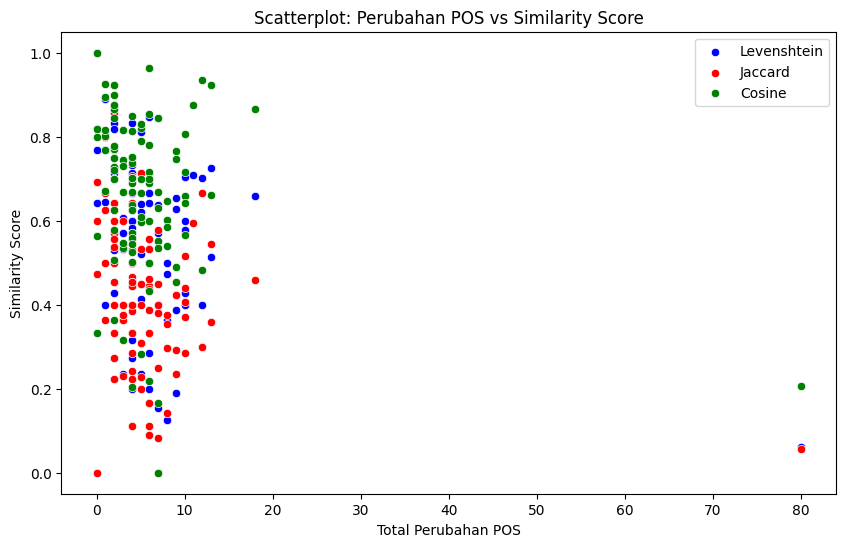

In [7]:
data['total_pos_changes'] = data['pos_changes'].apply(lambda x: sum(abs(v) for v in x.values()))

# Scatterplot hubungan perubahan POS dengan similarity scores
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['total_pos_changes'], y=data['levenshtein_sim'], label="Levenshtein", color="blue")
sns.scatterplot(x=data['total_pos_changes'], y=data['jaccard_sim'], label="Jaccard", color="red")
sns.scatterplot(x=data['total_pos_changes'], y=data['cosine_sim'], label="Cosine", color="green")
plt.xlabel("Total Perubahan POS")
plt.ylabel("Similarity Score")
plt.title("Scatterplot: Perubahan POS vs Similarity Score")
plt.legend()
plt.show()

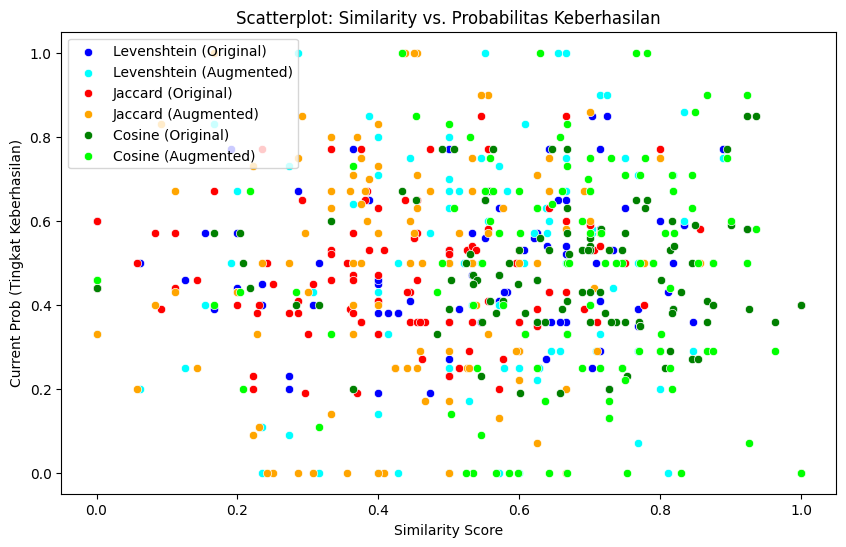

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['levenshtein_sim'], y=data['current-prob_x'], label="Levenshtein (Original)", color="blue")
sns.scatterplot(x=data['levenshtein_sim'], y=data['current-prob_y'], label="Levenshtein (Augmented)", color="cyan")

sns.scatterplot(x=data['jaccard_sim'], y=data['current-prob_x'], label="Jaccard (Original)", color="red")
sns.scatterplot(x=data['jaccard_sim'], y=data['current-prob_y'], label="Jaccard (Augmented)", color="orange")

sns.scatterplot(x=data['cosine_sim'], y=data['current-prob_x'], label="Cosine (Original)", color="green")
sns.scatterplot(x=data['cosine_sim'], y=data['current-prob_y'], label="Cosine (Augmented)", color="lime")

plt.xlabel("Similarity Score")
plt.ylabel("Current Prob (Tingkat Keberhasilan)")
plt.title("Scatterplot: Similarity vs. Probabilitas Keberhasilan")
plt.legend()
plt.show()


In [11]:
# Hitung perubahan probabilitas keberhasilan
data['prob-change'] = data['current-prob_y'] - data['current-prob_x']

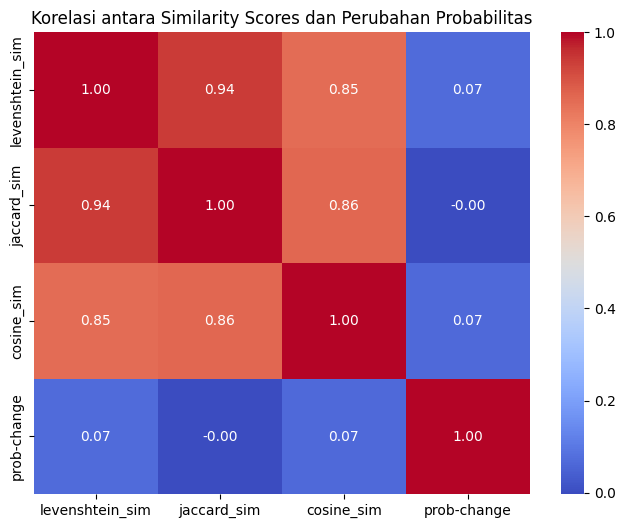

In [12]:
# Hitung korelasi antara similarity scores dan perubahan probabilitas
correlation_matrix = data[['levenshtein_sim', 'jaccard_sim', 'cosine_sim', 'prob-change']].corr()

# Tampilkan heatmap korelasi
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasi antara Similarity Scores dan Perubahan Probabilitas")
plt.show()

In [15]:
print("Korelasi antara Similarity Scores dan Perubahan Probabilitas:")
print(correlation_matrix)

Korelasi antara Similarity Scores dan Perubahan Probabilitas:
                 levenshtein_sim  jaccard_sim  cosine_sim  prob-change
levenshtein_sim         1.000000     0.938098    0.847278     0.068377
jaccard_sim             0.938098     1.000000    0.862491    -0.003256
cosine_sim              0.847278     0.862491    1.000000     0.065608
prob-change             0.068377    -0.003256    0.065608     1.000000


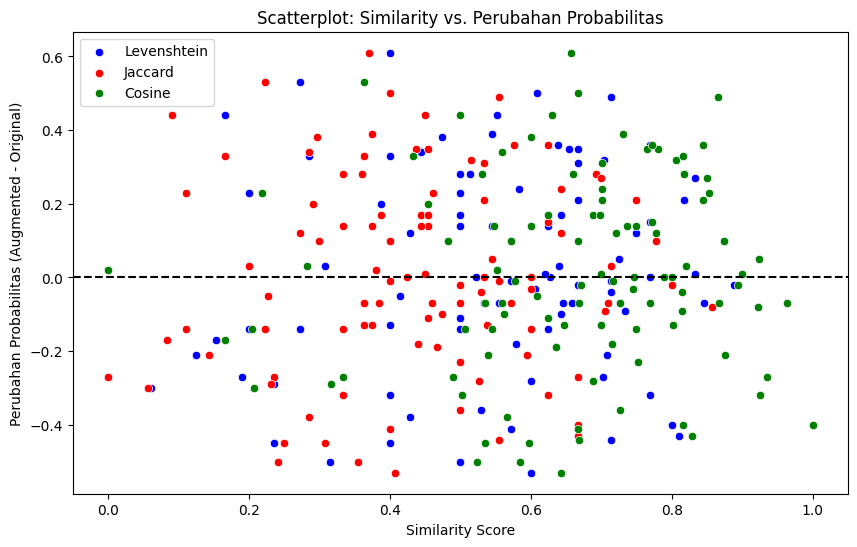

In [13]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=data['levenshtein_sim'], y=data['prob-change'], label="Levenshtein", color="blue")
sns.scatterplot(x=data['jaccard_sim'], y=data['prob-change'], label="Jaccard", color="red")
sns.scatterplot(x=data['cosine_sim'], y=data['prob-change'], label="Cosine", color="green")

plt.axhline(0, color='black', linestyle='--')  # Garis batas untuk melihat perubahan positif/negatif
plt.xlabel("Similarity Score")
plt.ylabel("Perubahan Probabilitas (Augmented - Original)")
plt.title("Scatterplot: Similarity vs. Perubahan Probabilitas")
plt.legend()
plt.show()


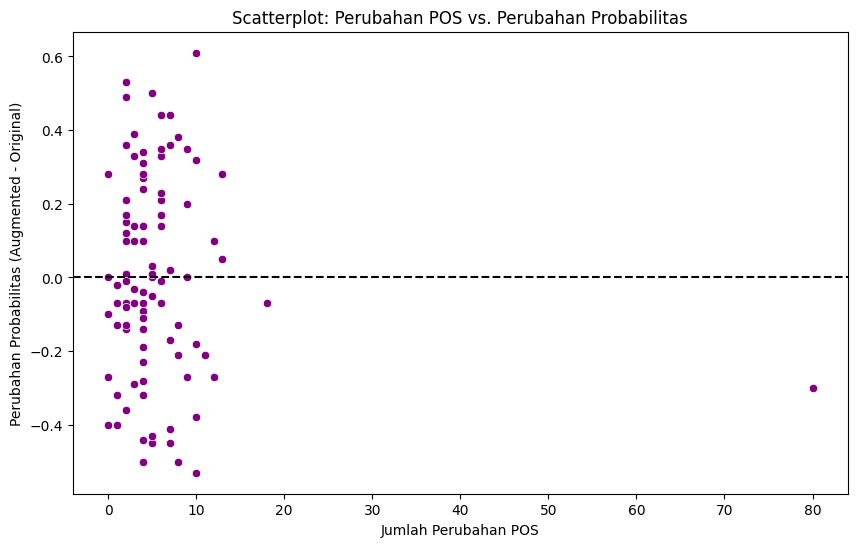

In [14]:
import ast

# Fungsi untuk menghitung perubahan POS dari original ke augmented
def hitung_perubahan_pos(pos_ori, pos_aug):
    pos_ori = ast.literal_eval(pos_ori)  # Konversi string menjadi dictionary
    pos_aug = ast.literal_eval(pos_aug)  
    perubahan = sum(abs(pos_ori.get(tag, 0) - pos_aug.get(tag, 0)) for tag in set(pos_ori.keys()).union(pos_aug.keys()))
    return perubahan

# Hitung jumlah perubahan POS
data['pos-change'] = data.apply(lambda row: hitung_perubahan_pos(row['pos-dist-original'], row['pos-dist']), axis=1)

# Scatterplot antara perubahan POS dan perubahan probabilitas
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['pos-change'], y=data['prob-change'], color="purple")

plt.xlabel("Jumlah Perubahan POS")
plt.ylabel("Perubahan Probabilitas (Augmented - Original)")
plt.title("Scatterplot: Perubahan POS vs. Perubahan Probabilitas")
plt.axhline(0, color='black', linestyle='--')  # Garis referensi
plt.show()
